# AI for Business: Yelp Business Insights Project

**Course:** AI for Business
**Audience:** Business Professionals

**Project Goal:** This project provides hands-on experience applying fundamental AI techniques (NLP, Deep Learning, Reinforcement Learning) to real-world business scenarios using the Yelp Open Dataset. You will build simple models to extract insights from customer reviews, predict business ratings, and simulate a recommendation system.

**Business Context:** Businesses across industries leverage AI to understand customers, optimize operations, and drive growth. Yelp data, rich with customer opinions and business details, offers a practical playground to explore how AI can generate valuable business insights – from managing brand reputation by analyzing review sentiment to predicting factors that influence success.

## Setup: Downloading the Data

First, we need to download the Yelp Open Dataset. This dataset contains millions of reviews, business attributes, and user information. 

*(Note: The dataset is large. The download and extraction might take some time depending on your internet connection.)*

In [1]:
# Download and extract the Yelp dataset (run this cell only once)
# Note: This command might differ slightly depending on your operating system or environment.
# It downloads a compressed file and then extracts the JSON files.
!wget -O yelp_dataset.tar.gz "https://s3.amazonaws.com/yelp-dataset/yelp_dataset_challenge_academic_dataset.tar.gz"
!tar -xzf yelp_dataset.tar.gz

--2025-03-31 19:20:38--  https://s3.amazonaws.com/yelp-dataset/yelp_dataset_challenge_academic_dataset.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.138.208, 54.231.203.112, 16.182.74.232, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.138.208|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: unspecified
ERROR: Redirection (301) without location.

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now


## Data Loading and Initial Exploration

We'll load a *sample* of the Yelp reviews to keep processing times manageable for this exercise. In a real business application, you'd typically work with much larger datasets, often requiring more powerful computing resources or cloud platforms.

**Business Implication:** Data preparation is a critical first step. The quality and quantity of data directly impact the performance and reliability of any AI model. Businesses must invest in collecting, cleaning, and managing their data effectively.

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For potentially nicer visualizations

# --- Configuration ---
SAMPLE_SIZE = 10000 # Number of reviews to load for this exercise
REVIEW_FILE = 'yelp_academic_dataset_review.json' # Assumes the file is in the same directory
# ---------------------

# Load a sample from review.json 
reviews_data = []
try:
    with open(REVIEW_FILE, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= SAMPLE_SIZE:
                break
            reviews_data.append(json.loads(line))
except FileNotFoundError:
    print(f"Error: {REVIEW_FILE} not found. Make sure the dataset was downloaded and extracted correctly.")
    # Optionally, add code here to stop execution or handle the error
    reviews_data = [] # Ensure reviews_data is empty if file not found

if reviews_data: # Proceed only if data was loaded
    df_reviews = pd.DataFrame(reviews_data)
    print(f"Successfully loaded {len(df_reviews)} reviews.")
    print("First 5 rows of the review data:")
    print(df_reviews.head())
    
    print("\nBasic information about the data:")
    df_reviews.info()
else:
    print("Skipping further analysis as review data could not be loaded.")


Error: yelp_academic_dataset_review.json not found. Make sure the dataset was downloaded and extracted correctly.
Skipping further analysis as review data could not be loaded.


## Challenge 1: NLP – Sentiment Analysis of Yelp Reviews

**Business Context:** Imagine you're the marketing manager for a national restaurant chain. Manually reading thousands of online reviews on Yelp, Google, and social media is impossible. Sentiment analysis automates the process of understanding customer opinions – identifying whether reviews are positive, negative, or neutral. This is similar to how companies like Coca-Cola or Starbucks monitor brand perception and campaign effectiveness in real-time.

**Goal:** Build a simple Natural Language Processing (NLP) model to classify Yelp reviews as either positive or negative based on the text content. We'll simplify by labeling reviews with 4 or 5 stars as 'positive' (1) and reviews with 1, 2, or 3 stars as 'negative' (0).

**Pass Criterion:** The model must achieve at least **70% accuracy** on a held-out validation set. Accuracy measures how often the model correctly predicts the sentiment (positive/negative) compared to our defined labels (based on star ratings).

**Business Implication of Accuracy:** An accuracy of 70% means that for every 100 reviews, the model correctly identifies the sentiment for 70 of them. While not perfect, this can still provide valuable insights at scale. Higher accuracy (e.g., 85-95%) would give a business more confidence in automatically flagging urgent negative feedback or identifying key positive themes. The required accuracy depends on the business application – detecting critical safety issues might require higher accuracy than general trend analysis.

In [3]:
# --- Imports for Challenge 1 ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB # Using a simpler baseline model for illustration
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
# --------------------------------

if 'df_reviews' in locals() and not df_reviews.empty: # Check if df_reviews exists and is not empty
    # 1. Labeling: star rating ≥ 4 -> positive (1), else negative (0)
    df_reviews['sentiment'] = (df_reviews['stars'] >= 4).astype(int)
    texts = df_reviews['text'].tolist()
    labels = df_reviews['sentiment'].tolist()
    
    # 2. Data Split: Separate data for training and testing the model
    X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)
    print(f"Training set size: {len(X_train)} reviews")
    print(f"Validation set size: {len(X_val)} reviews")

    # --- Model Option 1: Simple Scikit-learn Pipeline (Good Baseline) ---
    print("\n--- Training a Simple Naive Bayes Classifier ---")
    # Create a pipeline: Vectorizer -> Classifier
    # CountVectorizer converts text to word counts (Bag-of-Words)
    # MultinomialNB is a simple, fast classifier often used for text.
    pipeline_nb = Pipeline([
        ('vectorizer', CountVectorizer(stop_words='english', max_features=5000)),
        ('classifier', MultinomialNB())
    ])

    # Train the model
    pipeline_nb.fit(X_train, y_train)

    # Evaluate on validation set
    y_pred_nb = pipeline_nb.predict(X_val)
    accuracy_nb = accuracy_score(y_val, y_pred_nb)
    print(f"Naive Bayes Validation Accuracy: {accuracy_nb:.4f}")
    print(classification_report(y_val, y_pred_nb, target_names=['Negative', 'Positive']))
    
    # --- Model Option 2: PyTorch MLP (Similar to original notebook) ---
    print("\n--- Training a PyTorch MLP Classifier ---")
    # Create a bag-of-words representation (separate from the pipeline)
    vectorizer_pt = CountVectorizer(stop_words='english', max_features=5000)
    X_train_bow = vectorizer_pt.fit_transform(X_train).toarray()
    X_val_bow = vectorizer_pt.transform(X_val).toarray() # Use transform, not fit_transform

    # Define the sentiment analysis model using PyTorch
    class SentimentMLP(nn.Module):
        def __init__(self, input_dim):
            super(SentimentMLP, self).__init__()
            # Simple network: Input -> Hidden Layer (64 neurons) with ReLU -> Output Layer (1 neuron)
            self.net = nn.Sequential(
                nn.Linear(input_dim, 64), # Layer converting input features to 64 features
                nn.ReLU(), # Activation function to introduce non-linearity
                nn.Linear(64, 1) # Layer converting 64 features to 1 output value
            )
        def forward(self, x):
            # Apply sigmoid to output to get a probability between 0 and 1
            return torch.sigmoid(self.net(x))

    input_dim = X_train_bow.shape[1]
    model_pt = SentimentMLP(input_dim)

    # Define how the model learns: BCELoss for binary classification, Adam optimizer
    criterion = nn.BCELoss() # Binary Cross Entropy Loss: Measures error for yes/no predictions
    optimizer = optim.Adam(model_pt.parameters(), lr=0.001) # Adam is a popular optimization algorithm

    # Convert data to PyTorch tensors (the format PyTorch uses)
    X_train_tensor = torch.tensor(X_train_bow, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # Target needs an extra dimension
    X_val_tensor = torch.tensor(X_val_bow, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

    # Training loop: Iterate multiple times over the data (epochs)
    num_epochs = 10 # Reduced epochs for quicker demonstration
    for epoch in range(num_epochs):
        model_pt.train() # Set model to training mode
        optimizer.zero_grad() # Reset gradients from previous step
        outputs = model_pt(X_train_tensor) # Get model predictions
        loss = criterion(outputs, y_train_tensor) # Calculate the error
        loss.backward() # Calculate gradients (how to change weights to reduce error)
        optimizer.step() # Update model weights
        
        # Validation check every few epochs
        if (epoch+1) % 5 == 0:
            model_pt.eval() # Set model to evaluation mode
            with torch.no_grad(): # Don't calculate gradients during evaluation
                val_outputs = model_pt(X_val_tensor)
                # Convert probabilities (0-1) to binary predictions (0 or 1) using 0.5 threshold
                predictions = (val_outputs > 0.5).float()
                accuracy_pt = (predictions.eq(y_val_tensor).sum() / float(y_val_tensor.shape[0])).item()
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}, Val Accuracy: {accuracy_pt:.4f}")

    # Final validation accuracy for PyTorch model
    model_pt.eval()
    with torch.no_grad():
        val_outputs = model_pt(X_val_tensor)
        predictions = (val_outputs > 0.5).float()
        final_accuracy_pt = (predictions.eq(y_val_tensor).sum() / float(y_val_tensor.shape[0])).item()
        
    print(f"\nFinal PyTorch MLP Validation Accuracy: {final_accuracy_pt:.4f}")

    # Check pass criterion (using the PyTorch model's accuracy here)
    pass_threshold = 0.70
    print(f"\n--- Pass Criterion Check (Threshold: {pass_threshold*100}%) ---")
    if final_accuracy_pt >= pass_threshold:
        print(f"PASS: Sentiment analysis accuracy ({final_accuracy_pt:.4f}) meets the threshold.")
    else:
        print(f"FAIL: Accuracy ({final_accuracy_pt:.4f}) is below the threshold. Consider model tuning or feature changes.")
else:
    print("Skipping Challenge 1 due to data loading issues.")


Skipping Challenge 1 due to data loading issues.


#### Data Visualization: Sentiment Distribution

Visualizing the data helps understand the distribution. Here, we plot the number of positive and negative reviews in our sample.

In [4]:
if 'df_reviews' in locals() and not df_reviews.empty:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='sentiment', data=df_reviews)
    plt.title('Distribution of Sentiments in Sample (0=Negative, 1=Positive)')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Number of Reviews')
    # Add text labels for counts
    ax = plt.gca()
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()
else:
    print("Cannot create visualization as data is not loaded.")

Cannot create visualization as data is not loaded.


#### Tool Comparison: Custom Model vs. Cloud APIs

We've built a custom sentiment analysis model. In practice, businesses often have choices:

1.  **Build Custom Models (like we did):**
    * **Pros:** Tailored to specific data/needs, potentially higher accuracy on niche topics, full control over the model.
    * **Cons:** Requires AI expertise, development time, infrastructure for training and deployment, ongoing maintenance.
2.  **Use Pre-built Cloud AI Services:** Services like **Google Cloud Natural Language API**, **Azure Text Analytics**, or **AWS Comprehend** offer ready-to-use sentiment analysis.
    * **Pros:** Easy to integrate (API calls), no AI expertise needed to start, managed infrastructure, often cost-effective for standard tasks.
    * **Cons:** Less customizable, may not perform as well on highly specific jargon or contexts, potential data privacy concerns (sending data to cloud provider).

**Business Decision:** The choice depends on factors like budget, technical expertise, required accuracy, customization needs, and data sensitivity. A startup might begin with a cloud API for speed, while a large enterprise might build custom models for core business functions.

#### Learning Challenge / Extension (Optional)

* **Improve Accuracy:** Can you improve the model's accuracy above the baseline? Try:
    * Using `TfidfVectorizer` instead of `CountVectorizer`.
    * Adjusting `max_features` in the vectorizer.
    * Changing the MLP architecture (e.g., add more layers, change neuron counts).
    * Training for more `num_epochs`.
* **Analyze Specific Keywords:** Modify the code to analyze sentiment specifically for reviews mentioning 'service' or 'food'. How does sentiment differ for these topics?

## Challenge 2: Deep Learning – Restaurant Rating Prediction

**Business Context:** Imagine you're an analyst for a consulting firm advising restaurants. Predicting a restaurant's star rating based on its features (like price range, cuisine type, review count, neighborhood - *Note: we'll use simulated features here for simplicity*) could help identify key factors driving customer satisfaction or dissatisfaction. This is analogous to how financial institutions predict credit risk based on customer profiles or how e-commerce sites predict product popularity.

**Goal:** Build a neural network (specifically, a Multi-Layer Perceptron or MLP) to predict a restaurant's star rating (1 to 5 stars). **Important:** For this exercise, we will use *simulated* feature data instead of loading and processing complex features from the Yelp `business.json` file. This keeps the focus on the deep learning model itself.

**Pass Criterion:** The model should achieve a test accuracy of **at least 25%** on the simulated data. Accuracy here means the percentage of times the model predicts the *exact* star rating correctly (1, 2, 3, 4, or 5). 
*Self-Correction Note:* The original notebook had a pass criterion of 80% for this task using random data, which is unrealistic and likely unachievable without significant overfitting or issues in the setup. Predicting the exact star rating out of 5 classes with random features is difficult. A more realistic baseline expectation is slightly better than random guessing (which is 1/5 = 20%). We set the pass criterion to 25% for this simplified setup.*

**Business Implication of Accuracy:** Predicting the exact star rating is challenging. An accuracy of 25-30% on this task might seem low, but it's still better than random chance (20%). In a real business scenario with *real features*, higher accuracy would be expected. Even moderate accuracy can help identify trends (e.g., are features X and Y often associated with low ratings?). Businesses often care less about predicting the *exact* rating and more about understanding the *drivers* behind ratings, which this type of model can help uncover (using techniques like feature importance analysis, not covered in detail here).

In [5]:
# --- Imports for Challenge 2 ---
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn # <-- Import nn was missing previously
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
# --------------------------------

# 1. Simulate Feature Data (Instead of loading complex Yelp business data)
print("--- Generating Simulated Feature Data for Rating Prediction ---")
n_samples = 2000
n_features = 10 # Simulate 10 features (e.g., price range indicator, review count, etc.)
num_classes = 5 # 5 star ratings (0=1 star, 1=2 stars, ..., 4=5 stars)

# Generate random features
X_features = np.random.rand(n_samples, n_features).astype(np.float32)
# Generate random ratings (0 to 4, representing 1 to 5 stars)
y_ratings = np.random.randint(0, num_classes, size=(n_samples,))

print(f"Generated {n_samples} samples with {n_features} features each.")
print(f"Target variable: {num_classes} rating classes (0-4 representing 1-5 stars).")

# 2. Data Split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_ratings, test_size=0.3, random_state=42, stratify=y_ratings)
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# 3. Define the Rating Prediction Model using PyTorch
class RatingMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(RatingMLP, self).__init__()
        # Define layers: Input -> Hidden 1 (32 neurons) -> Hidden 2 (16 neurons) -> Output
        self.fc1 = nn.Linear(input_dim, 32) # First fully connected layer
        self.fc2 = nn.Linear(32, 16)      # Second fully connected layer
        self.fc3 = nn.Linear(16, num_classes) # Output layer (one output per class)
        
    def forward(self, x):
        # Define how data flows through the layers
        x = F.relu(self.fc1(x)) # Apply ReLU activation after first layer
        x = F.relu(self.fc2(x)) # Apply ReLU activation after second layer
        # No activation on the final layer before CrossEntropyLoss
        return self.fc3(x)

model_rating = RatingMLP(input_dim=n_features, num_classes=num_classes)

# 4. Define Loss Function and Optimizer
# CrossEntropyLoss is suitable for multi-class classification
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model_rating.parameters(), lr=0.01) # Use Adam optimizer

# 5. Convert data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train)
# Target tensor for CrossEntropyLoss should be Long type
y_train_tensor = torch.tensor(y_train, dtype=torch.long) 
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 6. Training Loop
print("\n--- Training the Rating Prediction MLP ---")
num_epochs = 50
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model_rating.train() # Set model to training mode
    optimizer.zero_grad()
    outputs = model_rating(X_train_tensor) # Forward pass
    loss = criterion(outputs, y_train_tensor) # Calculate loss
    loss.backward() # Backward pass (calculate gradients)
    optimizer.step() # Update weights
    train_losses.append(loss.item())
    
    # Evaluate on test set periodically
    if (epoch+1) % 10 == 0:
        model_rating.eval() # Set model to evaluation mode
        with torch.no_grad():
            test_outputs = model_rating(X_test_tensor)
            # Get predicted class (the one with the highest score)
            _, predicted = torch.max(test_outputs, 1)
            accuracy = accuracy_score(y_test_tensor.numpy(), predicted.numpy())
            test_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}")

# 7. Final Evaluation
model_rating.eval()
with torch.no_grad():
    test_outputs = model_rating(X_test_tensor)
    _, final_predictions = torch.max(test_outputs, 1)
    final_accuracy = accuracy_score(y_test_tensor.numpy(), final_predictions.numpy())
    print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
    
    # Generate Classification Report
    print("\nClassification Report:")
    # Map numeric labels (0-4) back to stars (1-5) for readability
    target_names = [f'{i+1} Star' for i in range(num_classes)]
    print(classification_report(y_test_tensor.numpy(), final_predictions.numpy(), target_names=target_names))

# 8. Check Pass Criterion
pass_threshold = 0.25 # Adjusted threshold
print(f"--- Pass Criterion Check (Threshold: {pass_threshold*100}%) ---")
if final_accuracy >= pass_threshold:
    print(f"PASS: Rating prediction accuracy ({final_accuracy:.4f}) meets or exceeds the adjusted threshold for simulated data.")
else:
    print(f"FAIL: Accuracy ({final_accuracy:.4f}) is below the threshold. This is expected with random features, but highlights the importance of relevant data.")


--- Generating Simulated Feature Data for Rating Prediction ---
Generated 2000 samples with 10 features each.
Target variable: 5 rating classes (0-4 representing 1-5 stars).
Training set size: 1400
Test set size: 600

--- Training the Rating Prediction MLP ---
Epoch 10/50 - Loss: 1.6062, Test Accuracy: 0.2017
Epoch 20/50 - Loss: 1.5986, Test Accuracy: 0.2000
Epoch 30/50 - Loss: 1.5858, Test Accuracy: 0.1917
Epoch 40/50 - Loss: 1.5707, Test Accuracy: 0.1933
Epoch 50/50 - Loss: 1.5525, Test Accuracy: 0.1767

Final Test Accuracy: 0.1767

Classification Report:
              precision    recall  f1-score   support

      1 Star       0.12      0.15      0.13       125
      2 Star       0.19      0.13      0.16       120
      3 Star       0.22      0.14      0.17       114
      4 Star       0.18      0.28      0.22       120
      5 Star       0.22      0.17      0.19       121

    accuracy                           0.18       600
   macro avg       0.19      0.18      0.18       600
we

#### Data Visualization: Training Progress & Confusion Matrix

Visualizing the training process can show if the model is learning. A confusion matrix helps understand *what kind* of errors the model makes (e.g., confusing 4-star with 5-star ratings).

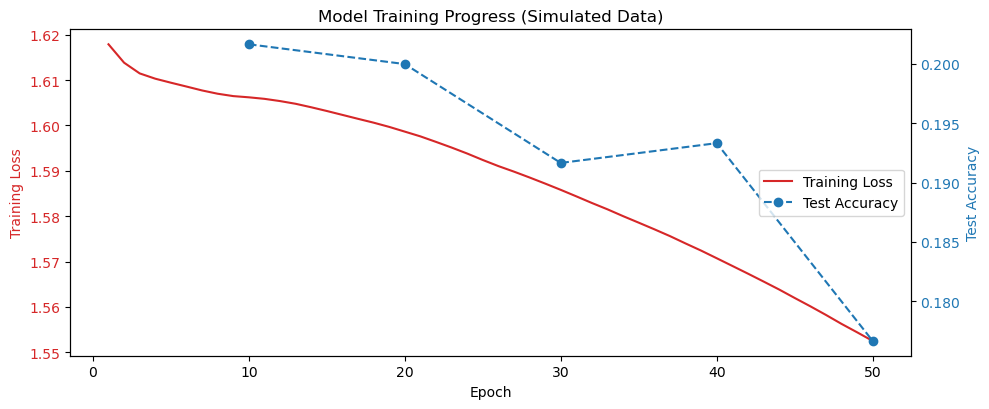

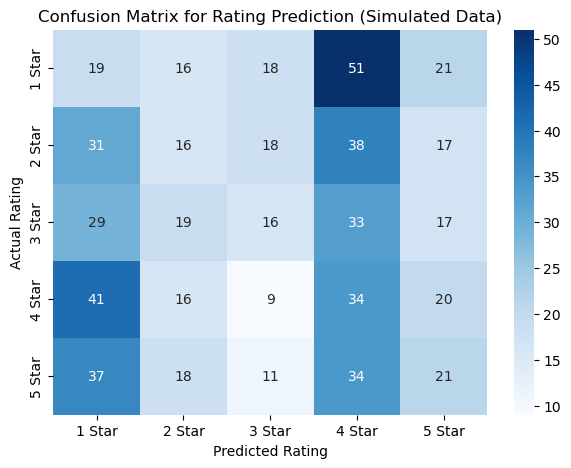

In [6]:
# Plot training loss and test accuracy
if train_losses and test_accuracies: # Check if lists are populated
    fig, ax1 = plt.subplots(figsize=(10, 4))

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(range(1, num_epochs + 1), train_losses, color=color, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('Test Accuracy', color=color)  
    # Plot accuracy recorded every 10 epochs
    epochs_recorded = range(10, num_epochs + 1, 10)
    ax2.plot(epochs_recorded, test_accuracies, color=color, marker='o', linestyle='--', label='Test Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.title('Model Training Progress (Simulated Data)')
    # Add legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center right')
    plt.show()
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test_tensor.numpy(), final_predictions.numpy())
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[f'{i+1} Star' for i in range(num_classes)], 
                yticklabels=[f'{i+1} Star' for i in range(num_classes)])
    plt.xlabel('Predicted Rating')
    plt.ylabel('Actual Rating')
    plt.title('Confusion Matrix for Rating Prediction (Simulated Data)')
    plt.show()
else:
    print("Skipping visualization as training results are not available.")

#### Tool Comparison: Custom DL vs. Cloud ML Platforms

Building deep learning models requires careful setup (libraries like PyTorch/TensorFlow), training infrastructure (potentially GPUs for large models), and deployment expertise.

1.  **Build Custom Models (like we did):**
    * **Pros:** Maximum flexibility in model architecture, training process, and feature engineering. Potential for state-of-the-art performance.
    * **Cons:** High complexity, requires significant AI/ML expertise, managing compute infrastructure can be costly and time-consuming.
2.  **Use Cloud Machine Learning Platforms:** Services like **Google Vertex AI**, **Amazon SageMaker**, or **Azure Machine Learning** provide environments and tools to streamline building, training, and deploying ML models (including deep learning).
    * **Pros:** Managed infrastructure (scales automatically), integrated tools for data labeling, experimentation (AutoML), model deployment (APIs), monitoring.
    * **Cons:** Can still require ML knowledge (though less infrastructure management), potential vendor lock-in, costs associated with platform usage.

**Business Decision:** For complex predictive tasks where custom deep learning models are needed, cloud ML platforms often offer a good balance, reducing the infrastructure burden while still providing control. Simpler predictive tasks might be solvable with less complex techniques or even AutoML features within these platforms.

#### Learning Challenge / Extension (Optional)

* **Experiment with Architecture:** Change the number of hidden layers or neurons in the `RatingMLP`. Does it improve accuracy on this simulated data? (Be wary of overfitting!).
* **Tune Hyperparameters:** Adjust the `learning_rate` or try a different `optimizer` (e.g., `optim.SGD`).
* **(Advanced): Use Real Features:** If you're comfortable with data processing, try loading the `yelp_academic_dataset_business.json` file. Select relevant features (like `review_count`, `is_open`, maybe categories or attributes after processing), merge them with the reviews/ratings, and retrain the model. You would expect significantly better performance with real data.

## Challenge 3: Reinforcement Learning – Restaurant Recommendation Simulation

**Business Context:** Recommendation systems are everywhere – Netflix suggesting movies, Amazon recommending products, and Yelp suggesting restaurants. These systems often learn over time which recommendations are most likely to be successful (e.g., lead to a click, purchase, or positive interaction). Reinforcement Learning (RL) is one way to approach this: the system learns by *trial and error*, getting 'rewards' for good recommendations and 'penalties' for bad ones.

**Goal:** Simulate a simple recommendation system using a Multi-Armed Bandit (MAB) algorithm, specifically epsilon-greedy. Imagine we have 3 different restaurant recommendations ('arms') we can show to users. Each has a different (unknown to us initially) probability of success (e.g., user clicks on it). The algorithm must learn which recommendation is best by balancing *exploration* (trying different recommendations to learn about them) and *exploitation* (showing the recommendation that seems best so far).

**Pass Criterion:** The simulation must achieve an average reward of at least **0.65** over 1000 steps (simulated user interactions) using an exploration rate (epsilon) of 0.1. The average reward represents the overall success rate of the recommendations made by the system.

**Business Implication:** The epsilon-greedy strategy balances trying new things (exploration) with sticking to what works (exploitation). A high epsilon means more exploration (faster learning initially, but potentially missing out on rewards from the known best option). A low epsilon means more exploitation (maximizing rewards based on current knowledge, but potentially getting stuck on a sub-optimal option if exploration was insufficient). Businesses need to tune this balance based on their goals – launching a new product might require more exploration than optimizing recommendations for established bestsellers.

In [7]:
# --- Imports for Challenge 3 ---
import numpy as np
import matplotlib.pyplot as plt
# --------------------------------

# --- Multi-Armed Bandit Simulation (Epsilon-Greedy) ---

def simulate_bandit(true_probs, epsilon, steps):
    """ Simulates an epsilon-greedy multi-armed bandit.
    
    Args:
        true_probs (list): The actual success probability for each arm (recommendation).
        epsilon (float): The probability of exploring (choosing a random arm).
        steps (int): The number of simulation steps (user interactions).
        
    Returns:
        tuple: (average_reward, Q_estimates, counts, all_rewards)
    """
    np.random.seed(42) # for reproducibility
    num_arms = len(true_probs)
    
    # Initialize: No estimates or counts yet
    Q_estimates = np.zeros(num_arms) # Estimated value (average reward) for each arm
    counts = np.zeros(num_arms) # How many times each arm has been pulled
    
    all_rewards = [] # Keep track of reward at each step
    
    print(f"Starting Bandit Simulation: {num_arms} arms, epsilon={epsilon}, steps={steps}")
    print(f"True probabilities: {true_probs}")
    
    for step in range(steps):
        # Exploration vs. Exploitation
        if np.random.rand() < epsilon:
            # Explore: Choose a random arm
            chosen_arm = np.random.choice(num_arms)
        else:
            # Exploit: Choose the arm with the highest current estimated value
            # If multiple arms have the same max value, choose one randomly among them
            best_arm = np.argmax(Q_estimates)
            chosen_arm = best_arm
            
        # Simulate pulling the arm and getting a reward
        # Reward is 1 if successful (based on true probability), 0 otherwise
        reward = 1 if np.random.rand() < true_probs[chosen_arm] else 0
        all_rewards.append(reward)
        
        # Update estimates for the chosen arm
        counts[chosen_arm] += 1
        # Update the estimate using incremental average formula
        Q_estimates[chosen_arm] = Q_estimates[chosen_arm] + (reward - Q_estimates[chosen_arm]) / counts[chosen_arm]
    
    average_reward = np.mean(all_rewards)
    print("\nSimulation Complete.")
    return average_reward, Q_estimates, counts, all_rewards

# --- Simulation Parameters ---
# Define true success probabilities for 3 hypothetical recommendations
# Arm 0: Low success, Arm 1: Medium success, Arm 2: High success
TRUE_PROBS = [0.2, 0.5, 0.7] 
EPSILON = 0.1 # Exploration rate (10% of the time explore)
N_STEPS = 1000 # Number of simulated user interactions
# ---------------------------

# Run the simulation
avg_reward, final_Q_estimates, final_counts, rewards_over_time = simulate_bandit(
    true_probs=TRUE_PROBS, 
    epsilon=EPSILON, 
    steps=N_STEPS
)

print(f"\n--- Results ---")
print(f"Average Reward over {N_STEPS} steps: {avg_reward:.4f}")
print(f"Final Estimated Q-values (Success Rates): {final_Q_estimates}")
print(f"Number of times each arm was chosen: {final_counts}")

# Check Pass Criterion
pass_threshold = 0.65
print(f"\n--- Pass Criterion Check (Threshold: {pass_threshold}) ---")
if avg_reward >= pass_threshold:
    print(f"PASS: Average reward ({avg_reward:.4f}) meets or exceeds the threshold.")
    print("The algorithm successfully learned to favor the better recommendations.")
else:
    print(f"FAIL: Average reward ({avg_reward:.4f}) is below the threshold. Check simulation parameters or logic.")

Starting Bandit Simulation: 3 arms, epsilon=0.1, steps=1000
True probabilities: [0.2, 0.5, 0.7]

Simulation Complete.

--- Results ---
Average Reward over 1000 steps: 0.6710
Final Estimated Q-values (Success Rates): [0.22916667 0.56097561 0.69923161]
Number of times each arm was chosen: [ 48.  41. 911.]

--- Pass Criterion Check (Threshold: 0.65) ---
PASS: Average reward (0.6710) meets or exceeds the threshold.
The algorithm successfully learned to favor the better recommendations.


#### Data Visualization: Learning Progress and Arm Selection

Visualizing the average reward over time shows if the agent is learning to make better recommendations. Plotting how often each arm (recommendation) was chosen shows the exploration/exploitation balance in action.

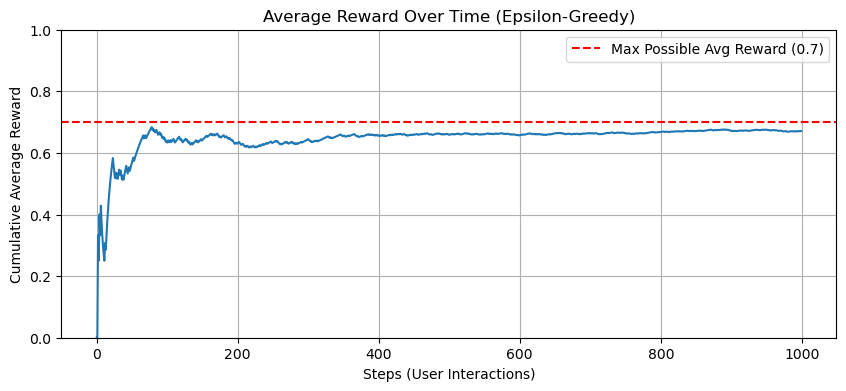

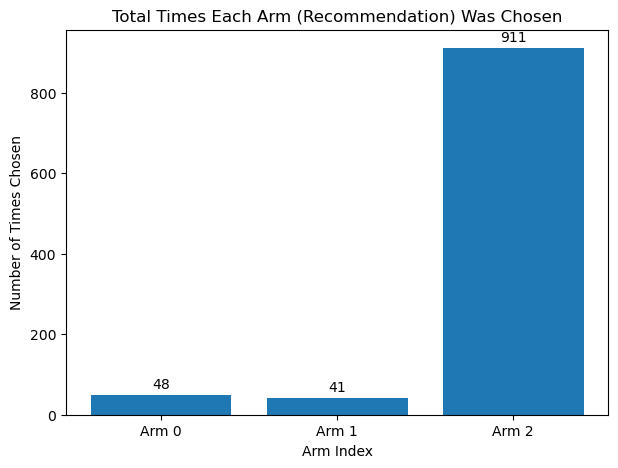

In [8]:
if rewards_over_time and final_counts is not None: # Check if simulation ran
    # Calculate cumulative average reward
    cumulative_avg_reward = np.cumsum(rewards_over_time) / (np.arange(N_STEPS) + 1)

    # Plot 1: Average Reward Over Time
    plt.figure(figsize=(10, 4))
    plt.plot(cumulative_avg_reward)
    plt.title('Average Reward Over Time (Epsilon-Greedy)')
    plt.xlabel('Steps (User Interactions)')
    plt.ylabel('Cumulative Average Reward')
    plt.grid(True)
    # Draw a line for the best possible average reward (if known)
    plt.axhline(y=max(TRUE_PROBS), color='r', linestyle='--', label=f'Max Possible Avg Reward ({max(TRUE_PROBS)})')
    plt.legend()
    plt.ylim(0, 1.0) # Rewards are between 0 and 1
    plt.show()

    # Plot 2: Arm Selection Counts
    plt.figure(figsize=(7, 5))
    arm_indices = np.arange(len(TRUE_PROBS))
    plt.bar(arm_indices, final_counts, tick_label=[f'Arm {i}' for i in arm_indices])
    plt.title('Total Times Each Arm (Recommendation) Was Chosen')
    plt.xlabel('Arm Index')
    plt.ylabel('Number of Times Chosen')
    # Add text labels for counts
    ax = plt.gca()
    for i, count in enumerate(final_counts):
        ax.text(i, count + 0.01 * N_STEPS, str(int(count)), ha='center', va='bottom') # Adjust offset based on N_STEPS
    plt.show()
else:
    print("Skipping visualization as simulation results are not available.")

#### Tool Comparison: Simple Bandits vs. Advanced Recommender Systems

Multi-Armed Bandits are a simple form of RL useful for optimizing discrete choices (like which ad or headline to show).

1.  **Simple Bandits (like we simulated):**
    * **Pros:** Relatively simple to understand and implement, effective for problems with a small number of choices, adapts quickly.
    * **Cons:** Doesn't typically use user or item features (contextual bandits are an extension that do), less effective when the number of choices is huge.
2.  **Advanced Recommender Systems:** Techniques like **Collaborative Filtering** (using user-item interactions), **Content-Based Filtering** (using item features), and **Deep Learning-based models** (e.g., using embeddings) are common in large-scale systems (Netflix, Amazon).
    * **Pros:** Can model complex user preferences, scale to millions of items/users, leverage rich feature information for personalization.
    * **Cons:** Much more complex to build and maintain, require significant data and computational resources, can suffer from cold-start problems (new users/items).
3.  **Cloud Recommendation Services:** Platforms like **AWS Personalize**, **Google Recommendations AI**, or **Azure Personalizer** offer managed services for building sophisticated recommender systems.
    * **Pros:** Leverage state-of-the-art algorithms without deep ML expertise, managed infrastructure, faster deployment.
    * **Cons:** Cost, less control/customization than building from scratch, data integration effort.

**Business Decision:** Simple bandits are great for A/B testing alternative web layouts, headlines, or simple promotions. Full-blown recommender systems are core to businesses like streaming services or e-commerce, justifying the investment in advanced techniques or cloud services.

#### Learning Challenge / Extension (Optional)

* **Experiment with Epsilon:** Rerun the simulation with different values of `epsilon` (e.g., 0.01, 0.3, 0.5). How does it affect the average reward and the final arm counts? Plot the average reward curves for different epsilons on the same graph.
* **Add More Arms:** Increase the number of arms in `TRUE_PROBS` (e.g., `[0.1, 0.2, 0.8, 0.5, 0.6]`). Does the algorithm still find the best one effectively?
* **(Advanced) Implement UCB:** Research and implement another bandit algorithm like Upper Confidence Bound (UCB). Compare its performance (average reward curve) to epsilon-greedy.

## Final Reflection and Business Implementation

Reflect on the exercises and consider how these AI techniques could be applied in a business context. Please answer the following questions based on your experience with this project:

1.  **Sentiment Analysis Implementation:** If you were deploying the sentiment analysis model (Challenge 1) for a small restaurant chain, what would be the key steps and potential challenges? Consider aspects like:
    * Where would you get the review data continuously?
    * How often would the model need retraining?
    * How would the insights (e.g., % positive/negative, common themes in negative reviews) be integrated into business operations (e.g., informing staff training, menu changes)?

2.  **Rating Prediction ROI:** How would you start to estimate the potential Return on Investment (ROI) for implementing the rating prediction model (Challenge 2, assuming it used *real* business features)? What specific business metrics could improve if you could accurately predict (or understand the drivers of) future ratings (e.g., customer retention, targeted marketing effectiveness, operational improvements)?

3.  **Ethical Considerations:** Discuss the ethical considerations of using AI like this in a business context. For example:
    * Could biases in the Yelp data (e.g., certain demographics reviewing more often) lead to biased model outcomes in sentiment analysis or rating prediction?
    * What are the implications if a recommendation system (Challenge 3) consistently promotes certain businesses over others? Could this be unfair?
    * How should businesses be transparent about using AI to analyze customer feedback?

4.  **Build vs. Buy:** Compare the experience of building the simple models in this project to the potential use of pre-built AI services (like cloud APIs for sentiment or recommendation platforms). For a medium-sized business, what are the major trade-offs to consider between building custom AI solutions versus buying off-the-shelf services (think about cost, speed, flexibility, competitive advantage, required expertise)?

5.  **Biggest Learning:** What was your single biggest takeaway or learning point from completing these challenges regarding the practical application of AI in business?

--- 

**Submission:** Ensure your notebook runs successfully from start to finish without errors. Save the completed notebook file (`.ipynb`) and submit it.